# NanoGPT - Bigram Model

To start with, we'll create a simple bigram model based on the tiny shakespeare dataset.
This code is directly taken from / inspired by: 

- https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=nql_1ER53oCf
- [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=1545s)

## Preparing our data

### Getting the data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.set_printoptions(precision=1, sci_mode=False, profile='short')
generator = torch.manual_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Read our input data:

In [ ]:
inputfile = './tiny_shakespeare.txt'
with open(inputfile, 'r', encoding='utf-8') as f:
    text = f.read()

print(f'the length of the shakespeare text is: {len(text)} characters')
print(f'the first 200 are: \n')
print(text[:200])

the length of the shakespeare text is: 1115394 characters
the first 200 are: 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'the size of our vocabulary is: {vocab_size}')
print(f'and looks like: {"".join(chars)}')

the size of our vocabulary is: 65
and looks like: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


We now need to be able to move from characters to tokens and back: from tokens to characters.  In a real language model, a token is more than a single character.  Real tokenizers like tiktoken are used.  In our case, we'll just simple map from character to token index and back:

In [ ]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda str: [stoi[c] for c in str]
decode = lambda idx_list: ''.join([itos[idx] for idx in idx_list])

In [ ]:
# let's test this:
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


We will now encode the entire dataset:

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
print(f'shape of data: {data.shape}')
print(f'a piece of this data: {data[:100]}')

shape of data: torch.Size([1115394])
a piece of this data: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


### Splitting our data in test and training sets

In [ ]:
train_fraction = .9
n = int(train_fraction*len(data))
train_data = data[:n]
val_data = data[n:]

We will look at our data using a given 'context_size' (also called 'block_size').  This is how many tokens we'll have maximum as input.  It can be less, in which case we'll pad our input with preceding padding characters.

In [ ]:
block_size = 8

We will look at each block of 8 characters (or less) and try to determine the next character.  This means that if we have 8 chars and we need to predict the nineth, we will need to shift the ground_truth vector by one:

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
x,y

(tensor([18, 47, 56, 57, 58,  1, 15, 47]),
 tensor([47, 56, 57, 58,  1, 15, 47, 58]))

Hidden in this series of 8 characters are 8 'exercises' as input when training our model:

In [ ]:
for i in range(block_size):
    print(f'{i+1} - when input is tensor {x[:i+1]} then output is: {y[i]}')

1 - when input is tensor tensor([18]) then output is: 47
2 - when input is tensor tensor([18, 47]) then output is: 56
3 - when input is tensor tensor([18, 47, 56]) then output is: 57
4 - when input is tensor tensor([18, 47, 56, 57]) then output is: 58
5 - when input is tensor tensor([18, 47, 56, 57, 58]) then output is: 1
6 - when input is tensor tensor([18, 47, 56, 57, 58,  1]) then output is: 15
7 - when input is tensor tensor([18, 47, 56, 57, 58,  1, 15]) then output is: 47
8 - when input is tensor tensor([18, 47, 56, 57, 58,  1, 15, 47]) then output is: 58


### Building batches of input samples for training

To train our model, we'll build batches of examples for the model to learn from.  We need to settle on a batch size for this:

In [ ]:
block_size = 8
batch_size = 4

In [ ]:
def get_batch(split, batch_size=batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(train_data) - block_size, (batch_size,)) # this gets us a tensor like [476250,  18899, 645194, 831150]
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [ ]:
xb, yb = get_batch('train')
xb, yb

(tensor([[57,  1, 46, 47, 57,  1, 50, 53],
         [ 1, 58, 46, 43, 56, 43,  1, 41],
         [17, 26, 15, 17, 10,  0, 32, 53],
         [57, 58,  6,  1, 61, 47, 58, 46]]),
 tensor([[ 1, 46, 47, 57,  1, 50, 53, 60],
         [58, 46, 43, 56, 43,  1, 41, 39],
         [26, 15, 17, 10,  0, 32, 53,  1],
         [58,  6,  1, 61, 47, 58, 46,  0]]))

In [ ]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [57] the target: 1
when input is [57, 1] the target: 46
when input is [57, 1, 46] the target: 47
when input is [57, 1, 46, 47] the target: 57
when input is [57, 1, 46, 47, 57] the target: 1
when input is [57, 1, 46, 47, 57, 1] the target: 50
when input is [57, 1, 46, 47, 57, 1, 50] the target: 53
when input is [57, 1, 46, 47, 57, 1, 50, 53] the target: 60
when input is [1] the target: 58
when input is [1, 58] the target: 46
when input is [1, 58, 46] the target: 43
when input is [1, 58, 46, 43] the target: 56
when input is [1, 58, 46, 43, 56] the target: 43
when input is [1, 58, 46, 43, 56, 43] the target: 1
when input is [1, 58, 46, 43, 56, 43, 1] the target: 41
when input is [1, 58, 46, 43, 56, 43, 1, 41] the target: 39
when input is [17] the target: 26
when input is [17, 26] the target: 15
when input is [17, 26, 15] the target: 17
when input is [17, 26, 15, 17] the target: 10
when input is [17, 26, 15, 17, 10] the target: 0
when input is [17, 26, 15, 17, 10, 0] the targ

`xb` is what will be our input into our transformer:

- every row represents a set of training examples, each drawn from the same set of consecutive characters, up to the `context_length`
- every column represents a token position and a sample, consisting of the token at the position in the row and all tokens that come before it

In [ ]:
xb

tensor([[57,  1, 46, 47, 57,  1, 50, 53],
        [ 1, 58, 46, 43, 56, 43,  1, 41],
        [17, 26, 15, 17, 10,  0, 32, 53],
        [57, 58,  6,  1, 61, 47, 58, 46]])

## Creating a Bigram model

### Create a Bigram module

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        # add an embedding layer for lookup of tokens (their index) and translating them in a vector:
        # for now, as the number of embedding dimensions, use our vocab_size
        # this then can be used to, given a char, lookup the probability of the next char
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, idx ,targets=None):
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the logits from idx, using our embedding table
        #                                        #    idx dimension: B x T
        logits = self.token_embedding_table(idx) # result dimension: B x T x C
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx
            

In [ ]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

def generate_some_text(model=m, max_new_tokens=100):
    generated_tokens = model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=max_new_tokens)[0].tolist()
    print(decode(generated_tokens))
    
generate_some_text()

torch.Size([32, 65])
tensor(4.7, grad_fn=<NllLossBackward0>)

F$z
E?kFwu
'buM-,Y3fYNsA3xp.mpsAqaZ-RUldc;F
M$GfYCUCkFO-bJbz-R;O!slp.FNsJDV'jRzIMQ'EdRbqAoWTjrniaIIa


### Train the Bigram module

To train our model parameters, we'll fetch an optimizer: Adam in this case.

In [ ]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

Text(0.5, 1.0, 'loss over time')

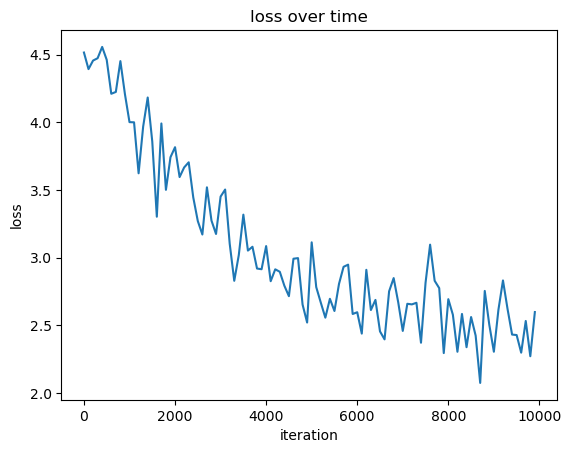

In [ ]:
batch_size = 32
steps=[]
losses=[]

for step in range(10000):
    # get a batch
    xb, yb = get_batch('train')
    
    # calculate the loss
    logits,loss = m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if step%100 == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss over time')

In [ ]:
generate_some_text()


Sx
AYO:
Tutthanot ucll tathoman?
SABs.O:
CEETunodwowfo t g tathfovy!
A'seathovizARU'st ine feirrdWca


See how this looks still like garbage, but already way better than it used to be!  Let's do this once more but up our batch size to see the impact on our loss curve.

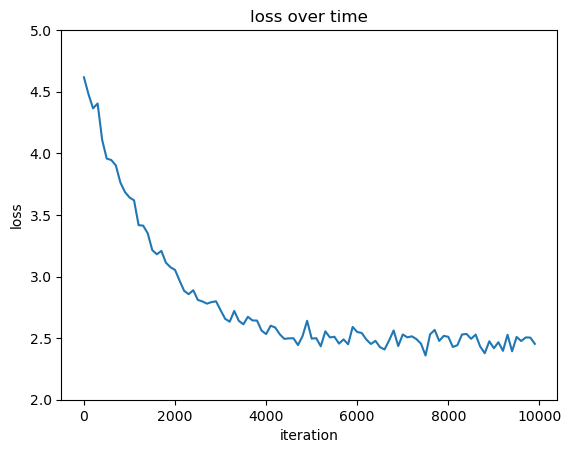

In [ ]:
m2 = BigramLanguageModel(vocab_size)
optimizer2 = torch.optim.Adam(m2.parameters(), lr=1e-3)
steps=[]
losses=[]

for step in range(10000):
    # get a batch
    xb, yb = get_batch('train', batch_size=64)
    
    # calculate the loss
    logits,loss = m2(xb,yb)
    optimizer2.zero_grad(set_to_none=True)
    loss.backward()
    optimizer2.step()
    
    if step%100 == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(2,5)
plt.title('loss over time')
plt.show()

We can say that increasing the `batch_size` smooths out our loss curve.

## Code Cleanup

See the [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=3509) for the section where some code is cleaned up first before moving on.

In [ ]:
# hyper parameters:
batch_size = 64
block_size = 8
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32             # number of embedding dimensions

class BigramLanguageModel2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # add an embedding layer for lookup of tokens (their index) and translating them in a vector:
        # for now, as the number of embedding dimensions, use our vocab_size
        # this then can be used to, given a char, lookup the probability of the next char
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        
        # add a language modeling head that will translate from token embeddings to logits:
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx ,targets=None):
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                        #    idx dimension: B x T
        tok_embd = self.token_embedding_table(idx) # token embeddings with result dimension: B x T x C
        logits = self.lm_head(tok_embd)            # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx
            

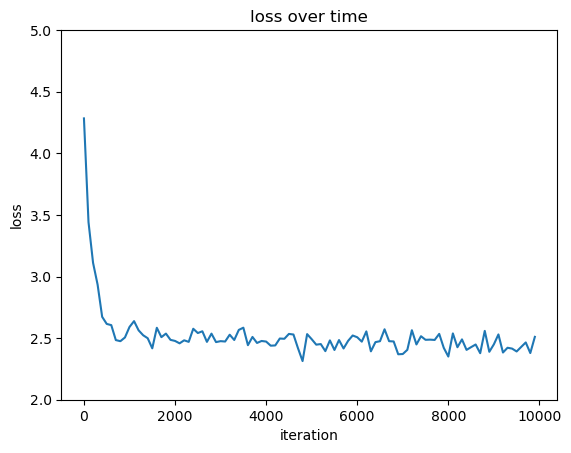

In [ ]:
model = BigramLanguageModel2()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

steps=[]
losses=[]

for step in range(max_iters):
    # get a batch
    xb, yb = get_batch('train', batch_size=batch_size)
    
    # calculate the loss
    logits,loss = model(xb,yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    if step%eval_interval == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(2,5)
plt.title('loss over time')
plt.show()

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 2.5102274417877197


Before we move on: it would also be useful for the network, not just to know the tokens itself but also their positions in the sequence.  For this we create a position embedding table:

In [ ]:
# hyper parameters:
batch_size = 64
block_size = 8
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32             # number of embedding dimensions

class BigramLanguageModel3(nn.Module):
    def __init__(self):
        super().__init__()
        
        # add an embedding layer for lookup of tokens (their index) and translating them in a vector:
        # for now, as the number of embedding dimensions, use our vocab_size
        # this then can be used to, given a char, lookup the probability of the next char
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        
        # add a language modeling head that will translate from token embeddings to logits:
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx ,targets=None):
        B,T = idx.shape()
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                    #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)           # token embeddings with result dimension:    B x T x C
        pos_embd = self.pos(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd # B x T x C
        logits = self.lm_head(x)            # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

By means of a small sample with random numbers, let's have a look to how the token embeddings are added to the positional embeddings.  For every item in the batch, for each of the 4 tokens, we add the embedding for the position of the token to the token embedding for for the token: 

In [ ]:
# code example: concatenating the token embedding with the positional embedding:
b2,t2,c2 = (2,4,6)  # batch of 2 sample, each having 4 tokens, which each is represented by n_embd of 6 dimensions

token_embedding = torch.randn((b2,t2,c2))
pos_embedding = torch.randn((t2,c2))
sum_embeddings = token_embedding + pos_embedding
token_embedding, pos_embedding, sum_embeddings

(tensor([[[-0.4,  0.8,  0.3,  0.4,  0.3, -0.4],
          [-0.2,  2.3, -0.3,  0.9,  0.7, -0.4],
          [-0.1, -0.5,  1.3, -0.2, -0.3,  1.0],
          [-1.3,  0.5, -0.5,  0.9,  1.3,  0.3]],
 
         [[ 0.1,  0.1, -0.2, -0.0, -0.7, -0.9],
          [-1.6,  0.3, -0.7, -1.6,  1.4,  1.0],
          [ 0.2,  0.1, -0.8, -0.9, -0.7, -2.6],
          [ 1.0, -0.6, -0.3, -0.7, -0.4, -0.1]]]),
 tensor([[    -0.1,      0.3,      0.2,     -0.4,      0.4,     -0.4],
         [     0.0,     -0.5,     -0.4,      1.3,      0.9,     -0.8],
         [     1.3,     -0.3,      1.1,     -0.1,     -1.2,     -0.2],
         [    -0.8,     -0.3,      0.3,      0.0,     -1.3,      1.1]]),
 tensor([[[-0.4,  1.2,  0.5,  0.0,  0.7, -0.8],
          [-0.2,  1.7, -0.7,  2.2,  1.6, -1.2],
          [ 1.2, -0.8,  2.4, -0.3, -1.5,  0.8],
          [-2.1,  0.2, -0.1,  0.9, -0.0,  1.4]],
 
         [[ 0.0,  0.5, -0.0, -0.4, -0.3, -1.3],
          [-1.6, -0.2, -1.2, -0.3,  2.3,  0.2],
          [ 1.5, -0.3,  0.3, -1.0

## Self Attention

Let's now see how self-attention works.  (See the video [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=3730) for more detail.

In [ ]:
b2,t2,c2 = (2,4,6) 
x = torch.randn(b2,t2,c2)
tril = torch.tril(torch.ones(t2,t2))
weights = torch.zeros((t2,t2))  # this line makes it so that currently there's an average being made of token and prev tokens, all with same weight
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=1)
out = weights @ x 
print(f'x: \n{x}')
print(f'------')
print(f'tril: \n{tril}')
print(f'------')
print(f'weights: \n{weights}')
print(f'------')
print(f'out: \n{out}')

x: 
tensor([[[    -1.3,      0.4,      0.0,     -1.7,     -0.7,      0.5],
         [     0.3,      0.4,      0.5,     -2.4,     -2.2,      0.4],
         [    -0.4,      0.9,     -0.1,      0.3,      1.1,      1.3],
         [    -0.5,      0.6,      0.1,     -0.6,      0.2,      1.8]],

        [[    -1.6,      0.9,      0.4,     -0.7,     -0.1,     -1.6],
         [    -1.2,     -0.5,     -0.4,     -0.9,     -1.0,      0.5],
         [    -0.6,      0.0,     -0.5,     -0.3,      0.5,     -0.1],
         [    -0.2,     -0.9,     -0.6,     -0.1,     -0.4,      0.6]]])
------
tril: 
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
------
weights: 
tensor([[1.0, 0.0, 0.0, 0.0],
        [0.5, 0.5, 0.0, 0.0],
        [0.3, 0.3, 0.3, 0.0],
        [0.2, 0.2, 0.2, 0.2]])
------
out: 
tensor([[[-1.3,  0.4,  0.0, -1.7, -0.7,  0.5],
         [-0.5,  0.4,  0.3, -2.1, -1.5,  0.4],
         [-0.5,  0.6,  0.2, -1.3, -0.6,  0.7],
         [-0.

Let's change this:

- every token, at every position, will emit two vectors:
  - query: "what am I looking for?"
  - key:   "what do I contain?"
- we then do a dot product between the keys and the queries to get this "affinity"

For a given token, its query will do a dot product with the keys of all the previous tokens.  That dot product will become our weights.  Weights was a matrix of dimensions `T x T` and multiplying `x` by those weights gave us the same dimensions as x itself: `B x T x C`.  

We calculate the:

- keys separately by multiplying a key-matrix by the input tensor; giving us a `B x T x head_size` (a vector of length head_size for every position)
- queries separately by multiplying a query-matrix by the input tensor; giving us a `B x T x head_size` (a vector of length head_size for every position)

Then we calculate the affinities between the queries and the keys, by doing a dot product, which can be done in batch using a multrix multiplication: <br/>
`weights = q @ k.T(-2,-1)` (taking into account dimensions; we do not want to touch the batch dimension and just switch the last two dimensions).  This gives us a result of shape `B x T x T`.  This means: a different `TxT` matrix for every item in our batch.  Note that the key and query matrix is the same for all of our items in our batch. 

In [ ]:
b2,t2,c2 = (2,4,6) 
x = torch.randn(b2,t2,c2)

# a single head of self-attention:
head_size = 8

key = nn.Linear(c2, head_size, bias=False)   # this will do matrix multiply with fixed weights
query = nn.Linear(c2, head_size, bias=False) # this will do matrix multiply with fixed weights

# by multiplying x by the linear layers for key and query, all of the samples, all of the tokens will, in parallel, calculate their key and query independently
# at this point in time, there has been no communication between tokens yet
k = key(x)   # (B x T x C) @ (C, head_size) => (B x T x head_size)
q = query(x)

# now all the queries will need to dot-product with all the keys:
weights = q @ k.transpose(-2,-1)  # (B x T x head_size) @ (B x head_size x T) => B x T x T

# this means that for every row in our batch B, we will have a weight matrix T x T now with the affinities
# we will use this instead of the weights matrix that we filled with zeroes before.  
# what we did before was:
#   weights = torch.zeros((t2,t2))  # this line makes it so that currently there's an average being made of token and prev tokens, all with same weight

tril = torch.tril(torch.ones(t2,t2))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=1)
out = weights @ x 
print(f'x: \n{x}')
print(f'------')
print(f'tril: \n{tril}')
print(f'------')
print(f'weights: \n{weights}')
print(f'------')
print(f'out: \n{out}')

x: 
tensor([[[ 2.4,  0.6,  1.4, -0.7,  0.9,  0.6],
         [-0.5,  0.5, -1.0, -1.0,  0.1, -2.0],
         [ 0.1,  1.3,  0.2,  0.1,  0.6, -0.2],
         [-0.0, -0.7, -2.2, -0.3,  2.4,  1.3]],

        [[-0.2,  0.0,  1.2, -0.8,  0.3, -0.7],
         [ 1.8,  0.8,  0.2,  1.0, -0.2,  1.4],
         [ 0.1,  2.0, -1.0, -0.4,  0.1,  1.1],
         [ 0.2, -0.9,  0.3,  0.2,  2.2, -0.4]]])
------
tril: 
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
------
weights: 
tensor([[[0.7, 0.0, 0.0, 0.0],
         [0.0, 0.5, 0.0, 0.0],
         [0.1, 0.3, 0.5, 0.0],
         [0.2, 0.3, 0.5, 1.0]],

        [[0.3, 0.0, 0.0, 0.0],
         [0.2, 0.3, 0.0, 0.0],
         [0.1, 0.5, 0.5, 0.0],
         [0.4, 0.3, 0.5, 1.0]]], grad_fn=<SoftmaxBackward0>)
------
out: 
tensor([[[ 1.6,  0.4,  0.9, -0.4,  0.6,  0.4],
         [-0.2,  0.2, -0.4, -0.5,  0.1, -0.9],
         [ 0.1,  0.8, -0.0, -0.3,  0.4, -0.5],
         [ 0.4,  0.3, -2.1, -0.7,  2.9,  0.8]]

See how `weights`:

- has a different weights matrix for every batch element
- (after all: every batch element has different tokens on different positions)
- is no longer evenly distributed but some element positions have more weight than others

To get to the final stage of self-attention, we don't multiply our input vector `x` directly with our weights, instead we compute a `value` by:

- creating a value matrix
- calculating the value by doing a matrix multiply of our input with the value matrix
- use as our output, not just the `weights @ x` but instead now do `weights @ v`

So instead of the token embeddings directly, for the purposes of this attention head, it is actually `v`, the value tensor, that gets aggregated for every token and its past tokens.

In [ ]:
b2,t2,c2 = (2,4,6) 
x = torch.randn(b2,t2,c2)

# a single head of self-attention:
head_size = 8

key = nn.Linear(c2, head_size, bias=False)   # this will do matrix multiply with fixed weights
query = nn.Linear(c2, head_size, bias=False) # this will do matrix multiply with fixed weights
value = nn.Linear(c2, head_size, bias=False) # this will do matrix multiply with fixed weights

k = key(x)   # (B x T x C) @ (C, head_size) => (B x T x head_size)
q = query(x)

weights = q @ k.transpose(-2,-1) * (head_size**-0.5)  # (B x T x head_size) @ (B x head_size x T) => B x T x T
# multiplication by square root of head_size is needed to keep distribution equal

tril = torch.tril(torch.ones(t2,t2))
weights = weights.masked_fill(tril == 0, float('-inf'))  # this is what makes this an decoder block instead of an encoder block (where this is left off)
weights = F.softmax(weights, dim=1)

v = value(x) # (B x T x C) @ (C, head_size) => (B x T x head_size)

out = weights @ v # (B x T x T) @ (B x T x head_size) => (B x T x head_size), here: 2 x 4 x 8

print(f'x: \n{x}')
print(f'------')
print(f'tril: \n{tril}')
print(f'------')
print(f'weights: \n{weights}')
print(f'------')
print(f'v: \n{v}')
print(f'------')
print(f'out: \n{out}')

x: 
tensor([[[-0.1, -1.4,  1.6, -2.1,  0.2,  0.0],
         [ 0.0,  1.2,  0.3,  0.2,  1.4, -0.4],
         [-0.1,  1.1, -0.1,  0.7, -1.2,  1.2],
         [ 0.6,  1.3,  1.7, -0.5, -1.2, -2.1]],

        [[-0.2, -0.5,  0.2,  0.6,  0.4, -0.6],
         [ 0.4, -0.7,  0.7, -0.6, -0.2,  0.9],
         [ 0.4,  0.9, -1.0, -0.3,  2.0,  1.1],
         [-0.3, -1.7, -0.2,  1.7, -0.6,  1.0]]])
------
tril: 
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
------
weights: 
tensor([[[0.2, 0.0, 0.0, 0.0],
         [0.4, 0.4, 0.0, 0.0],
         [0.2, 0.3, 0.4, 0.0],
         [0.2, 0.3, 0.6, 1.0]],

        [[0.2, 0.0, 0.0, 0.0],
         [0.2, 0.3, 0.0, 0.0],
         [0.2, 0.5, 0.6, 0.0],
         [0.3, 0.3, 0.4, 1.0]]], grad_fn=<SoftmaxBackward0>)
------
v: 
tensor([[[ 0.6,  0.3, -0.1,  1.2, -0.2, -0.5,  0.1,  0.3],
         [ 0.5,  0.4, -0.4, -0.2, -0.3, -0.0,  0.4,  0.6],
         [-0.3, -0.5,  0.6, -0.9,  0.3,  0.4, -0.2, -0.7],
         [ 1

Keys, queries and values in our case come from the same `x` vector; which is why we call this _self-attention_ .  This does not _have_ to be the case always; there's something called cross-attention as well.

## Scaled Dot Product Attention Module

We will not create a self-attention module as described in [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=4761)



In [ ]:
# hyper parameters:
batch_size = 64
block_size = 8
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32             # number of embedding dimensions

In [ ]:
def get_batch(split, batch_size=batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(train_data) - block_size, (batch_size,)) # this gets us a tensor like [476250,  18899, 645194, 831150]
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

def generate_some_text(model=m, max_new_tokens=100):
    generated_tokens = model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=max_new_tokens)[0].tolist()
    print(decode(generated_tokens))

In [ ]:
class Head(nn.Module):
    """One head of self-attention"""
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)    # n_embd x head_size
        self.query = nn.Linear(n_embd, head_size, bias=False) 
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x)   # (B x T x C) @ () => B x T x C
        q = self.query(x) # B x T x C
        
        # compute attention scores:
        weights = q @ k.transpose(-2,-1) * (C**-0.5) # BxTxC @ BxCxT       => BxTxT
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # BxTxT
        weights = F.softmax(weights, dim=-1) # BxTxT
        
        # do weighted aggregation:
        v = self.value(x) # BxTxC
        out = weights @ v # BxTxT @ BxTxC => BxTxC
        return out
    

In [ ]:
class BigramLanguageModel4(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        
        # add self-attention head:
        self.self_att_head = Head(n_embd)
        
        # add a language modeling head that will translate from token embeddings to logits:
        self.lm_head = nn.Linear(n_embd, vocab_size, device=device)
        
    def forward(self, idx ,targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd   # B x T x C
        x = self.self_att_head(x) # appy a single head of self-attention: B x T x C
        logits = self.lm_head(x)            # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

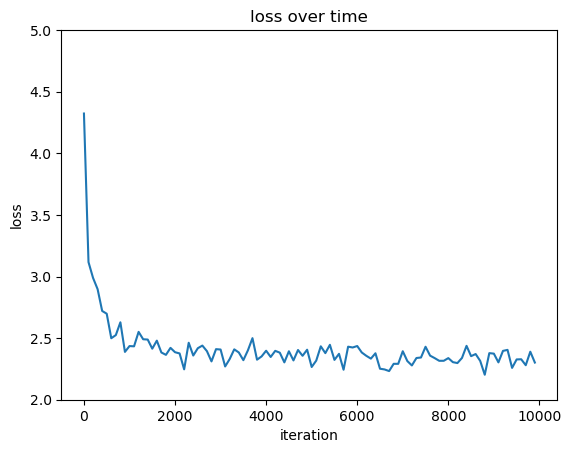

In [ ]:
model = BigramLanguageModel4()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

steps=[]
losses=[]

for step in range(max_iters):
    # get a batch
    xb, yb = get_batch('train', batch_size=batch_size)
    
    # calculate the loss
    logits,loss = model(xb,yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    if step%eval_interval == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(2,5)
plt.title('loss over time')
plt.show()

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')
generate_some_text(model=model)

last recorded loss was 2.3017351627349854

O: asafnte th'd tes thut mod thand he, preckn,
Ohe thme, achile lapilisers we ss, tean,
Theelu.
GLAB


## Multi-Head Attention Module

We will now apply multiple heads of attention, in parallel, and then concatenate the results.

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of attention in parallel"""
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        
    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim = -1)

In [ ]:
class BigramLanguageModel5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        
        # add multiple self-attention heads:
        # each head will typically be smaller correspondingly (that's why we divide n_embd by number of channels)
        # if we then concat the output for each, we'll get back to our original n_embd = 32
        self.self_att_heads = MultiHeadAttention(4, n_embd//4) # 4 heads of 32/4=8-dimensional self-attention
        
        # add a language modeling head that will translate from token embeddings to logits:
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx ,targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd    # B x T x C
        x = self.self_att_heads(x) # appy self-attentions in parallel: B x T x C
        logits = self.lm_head(x)   # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

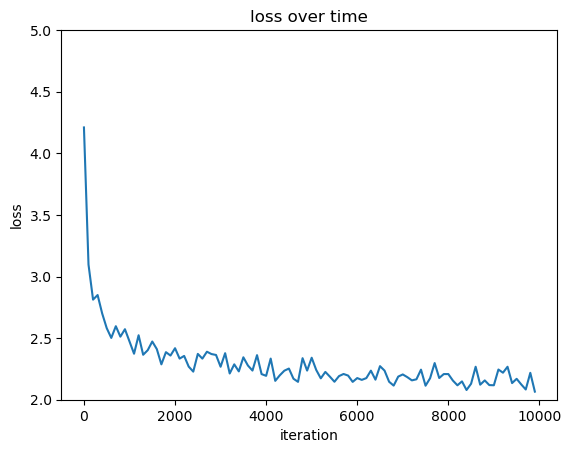

In [ ]:
model = BigramLanguageModel5()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

steps=[]
losses=[]

for step in range(max_iters):
    # get a batch
    xb, yb = get_batch('train', batch_size=batch_size)
    
    # calculate the loss
    logits,loss = model(xb,yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    if step%eval_interval == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(2,5)
plt.title('loss over time')
plt.show()

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 2.065643548965454


In [ ]:
generate_some_text(model=model, max_new_tokens=100)


ERTZAK:
Miced that mang youghthy
brothaves.
Ser url hat gre me machand He.

No dieen with upore cans


## Optimizing Multi-Head Attention

### Introducing a Feed-Forward layer

We have a better result, but still a long way to go.  So far, we went too fast in calculating the logits.  There's not much compute in between.  To fix this, we'll introduce a small feedforward layer (basically a normal Linear Layer with a non-linearity, being a ReLu.)

This feed-forward layer happens on a per-token basis.  This means that all tokens do this independently.  (Also [see video here](https://youtu.be/kCc8FmEb1nY?t=5168))

In [ ]:
class FeedForward(nn.Module):
    """Single Layer followed by a non-linearity"""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.net(x)

In [ ]:
class BigramLanguageModel6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        self.self_att_heads = MultiHeadAttention(4, n_embd//4) # 4 heads of 32/4=8-dimensional self-attention
        self.feed_fwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx,targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd    # B x T x C
        x = self.self_att_heads(x) # appy self-attentions in parallel: B x T x C
        x = self.feed_fwd(x)
        logits = self.lm_head(x)   # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

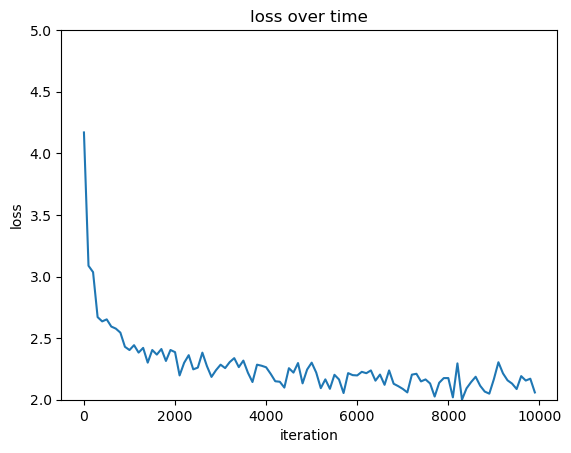

In [ ]:
model = BigramLanguageModel6()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

steps=[]
losses=[]

for step in range(max_iters):
    # get a batch
    xb, yb = get_batch('train', batch_size=batch_size)
    
    # calculate the loss
    logits,loss = model(xb,yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    if step%eval_interval == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(2,5)
plt.title('loss over time')
plt.show()

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 2.0591189861297607


Our loss keeps going down from:

- 2.553
- 2.298
- 2.150
- 2.081

In [ ]:
generate_some_text(model=model, max_new_tokens=100)


GRUENTANUM:
To shou and wordomest;
Alcome ming I he wours old!-
I in Wh hut is ther'd ban no wersay



### Creating multiple Blocks

As explained in [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=5193) we will now have multiple blocks with each

In [ ]:
# hyper parameters:
batch_size = 64
block_size = 8
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32             # number of embedding dimensions

In [ ]:
class Head(nn.Module):
    """One head of self-attention"""
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)    # n_embd x head_size
        self.query = nn.Linear(n_embd, head_size, bias=False) 
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x)   # (B x T x C) @ () => B x T x C
        q = self.query(x) # B x T x C
        
        # compute attention scores:
        weights = q @ k.transpose(-2,-1) * (C**-0.5) # BxTxC @ BxCxT       => BxTxT
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # BxTxT
        weights = F.softmax(weights, dim=-1) # BxTxT
        
        # do weighted aggregation:
        v = self.value(x) # BxTxC
        out = weights @ v # BxTxT @ BxTxC => BxTxC
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of attention in parallel"""
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        
    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim = -1)

In [ ]:
class FeedForward(nn.Module):
    """Single Layer followed by a non-linearity"""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """Transformer Block: communications followed by computation"""
    
    def __init__(self,n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embd)
        
    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

In [ ]:
class BigramLanguageModel7(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4)
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd    # B x T x C
        x = self.blocks(x)
        logits = self.lm_head(x)   # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

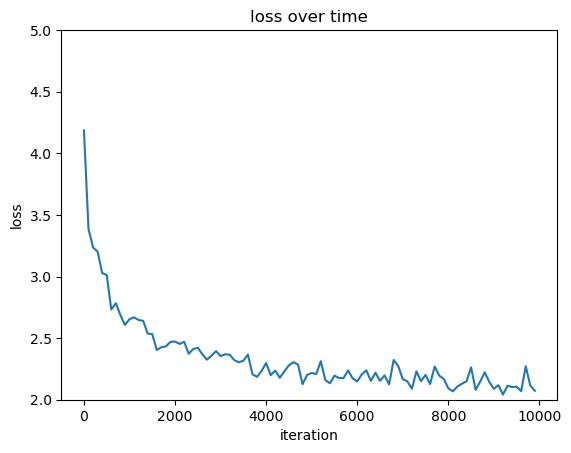

In [ ]:
model = BigramLanguageModel7()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

steps=[]
losses=[]

for step in range(max_iters):
    # get a batch
    xb, yb = get_batch('train', batch_size=batch_size)
    
    # calculate the loss
    logits,loss = model(xb,yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    if step%eval_interval == 0 :
        steps.append(step)
        losses.append(loss.item())
        # print(f'loss for iteration {step} is: {loss}')

plt.plot(steps, losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(2,5)
plt.title('loss over time')
plt.show()

When you try to run this, the results won't be stellar.  The reason is that this is quite a deep neural net, which is not yet optimized.

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 2.0725607872009277


In [ ]:
generate_some_text(model=model, max_new_tokens=100)


Go be'ts.

EULYIZDA:
O, Rpefoul the gosonn, hear now of him your dis the barete sheir bouls thou Iw 


Our loss keeps going down from:

- 2.553
- 2.298 (scaled dot product attention)
- 2.150 (multi-head attention)
- 2.081 (feed fwd layer)
- 2.16  => blocks without optimization - this is worse; but we're dealing with a deep network here

### Optimizations

There's two optimizations that will enable us to really use a deep network like this.  Discussed in the video here: [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=5296)

- Residual Connections (also called skip-connections) - see: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
- Layer Normalization

#### Residual Connections

A residual connection, also known as a skip connection, is a way to add the input of a layer to its output, bypassing the layer's activation function. This is done by adding the input tensor to the output tensor, and passing the sum through the next layer's activation function. The output of the layer with the skip connection is therefore the sum of the original output and the original input.

The purpose of the residual connection is to help alleviate the vanishing gradient problem, which can occur when training deep neural networks. In traditional neural networks, gradients can become very small as they propagate backwards through many layers, making it difficult to update the weights of the earlier layers. By adding a residual connection, the gradient can flow directly from the output to the input of the layer, bypassing the activation function and allowing the gradients to be directly added together.

This can be thought of as a "shortcut" for the gradient, which can help to propagate it more efficiently through the network. By enabling the gradients to flow directly through the skip connection, the residual connection helps to ensure that the weights of the earlier layers are updated more effectively during training.

In summary, a residual connection or skip connection is a way to add the input of a layer to its output, bypassing the layer's activation function. This helps to alleviate the vanishing gradient problem and enable more efficient gradient flow through the network during training. The addition of the input and output tensors during the residual connection is important for allowing gradients to be computed with addition, enabling more efficient weight updates during training.

In [ ]:
# hyper parameters:
batch_size = 64
block_size = 8
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32             # number of embedding dimensions

class Head(nn.Module):
    """One head of self-attention"""
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)    # n_embd x head_size
        self.query = nn.Linear(n_embd, head_size, bias=False) 
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x)   # (B x T x C) @ () => B x T x C
        q = self.query(x) # B x T x C
        
        # compute attention scores:
        weights = q @ k.transpose(-2,-1) * (C**-0.5) # BxTxC @ BxCxT       => BxTxT
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # BxTxT
        weights = F.softmax(weights, dim=-1) # BxTxT
        
        # do weighted aggregation:
        v = self.value(x) # BxTxC
        out = weights @ v # BxTxT @ BxTxC => BxTxC
        return out

We'll add a projection back into the residual pathway to our `MultiHeadAttention`and `FeedForward` - which is just a linear transformation of the output of this layer:

In [ ]:
class FeedForward(nn.Module):
    """Single Layer followed by a non-linearity"""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
            nn.Linear(n_embd, n_embd)  # projection back into residual pathway
        )
        
    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):
    """Multiple heads of attention in parallel"""
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd) # projection
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out)  # projection
        return out

We'll change the block to use a residual connection:

In [ ]:
class Block(nn.Module):
    """Transformer Block: communications followed by computation"""
    
    def __init__(self,n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embd)
        
    def forward(self, x):
        x = x + self.sa(x)    # the "x + ... is the skip connection here"
        x = x + self.ffwd(x)  # the "x + ... is the skip connection here"
        return x

In [ ]:
class BigramLanguageModel8(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4)
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd    # B x T x C
        x = self.blocks(x)
        logits = self.lm_head(x)   # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

In [ ]:
def train_model_and_show_result(model):
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

    steps=[]
    losses=[]

    for step in range(max_iters):
        # get a batch
        xb, yb = get_batch('train', batch_size=batch_size)

        # calculate the loss
        logits,loss = model(xb,yb)
        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()

        if step%eval_interval == 0 :
            steps.append(step)
            losses.append(loss.item())
            # print(f'loss for iteration {step} is: {loss}')

    plt.plot(steps, losses)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.ylim(1,5)
    plt.title('loss over time')
    plt.show()
    
    return losses

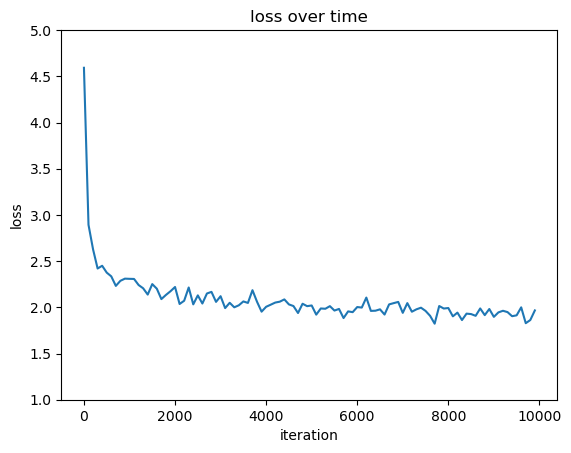

In [ ]:
model = BigramLanguageModel8()
model.to(device)
losses = train_model_and_show_result(model)

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 1.9664623737335205


In [ ]:
generate_some_text(model=model, max_new_tokens=100)


DUKEn
Mears as now:
Keve manasy Va cound for your was trake you, many as Bolew'd be sitculfintientle


Our loss keeps going down from:

- 2.553
- 2.298 (scaled dot product attention)
- 2.150 (multi-head attention)
- 2.081 (feed fwd layer)
- 2.16  => blocks without optimization - this is worse; but we're dealing with a deep network here
- 1.96 (blocks optimized with residual pathways)

In addition, and as described in [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=5505) we'll now make sure our inner layer of our feedforward module has dimension 4 times bigger than the input our output.

In [ ]:
class FeedForward(nn.Module):
    """Single Layer followed by a non-linearity"""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)  # projection back into residual pathway
        )
        
    def forward(self, x):
        return self.net(x)

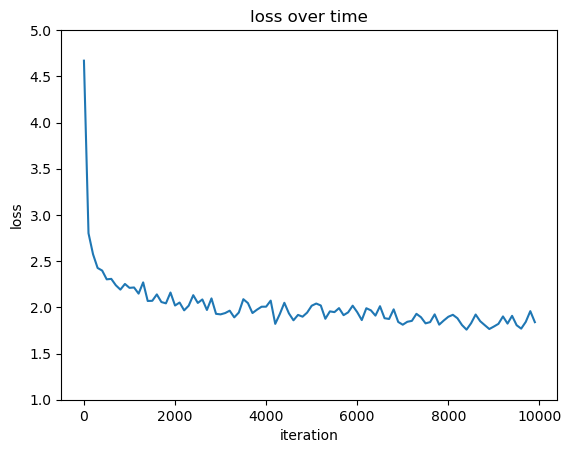

In [ ]:
model = BigramLanguageModel8()
model.to(device)
losses = train_model_and_show_result(model)

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 1.8393092155456543


In [ ]:
generate_some_text(model=model, max_new_tokens=100)


Som.

KING RICHENRY VI
holumf:
Do with sybonay them what
Yours of stnous acarge, fards, Sir;
Master.


Our loss keeps going down from:

- 2.553
- 2.298 (scaled dot product attention)
- 2.150 (multi-head attention)
- 2.081 (feed fwd layer)
- 2.16  => blocks without optimization - this is worse; but we're dealing with a deep network here
- 1.96 (blocks optimized with residual pathways)
- 1.855 (inner layer of feedforward is 4 x size of input)

#### Layer Norm

See [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=5583) <br/>
This is the paper on [Layer Normalization](https://arxiv.org/abs/1607.06450)

LayerNorm is similar to batchnorm.  Batch normalization made sure that across the batch dimension, every neuron had zero mean and a std deviation of 1.  Batchnorm worked by substracting the mean and dividing by the std dev:




In [ ]:
a = torch.tensor(np.array([2.0, 4, 1 ,5]))
a_mean = torch.mean(a)
a_stdev = torch.std(a)

print(f'the mean is: {a_mean}')
print(f'the std dev is: {a_stdev}')

the mean is: 3.0
the std dev is: 1.8257418583505538


In [ ]:
b_min_mean = (a-a_mean)
b_mean = torch.mean(b_min_mean)
b_stdev = torch.std(b_min_mean)
b_min_mean_div_std = b_min_mean / a_stdev
b_min_mean_dev_std_std = torch.std(b_min_mean_div_std)
print(f'the mean after substracting the mean of every number in the tensor is: {b_mean}')
print(f'the std dev after substracting the mean of every number in the tensor is: {b_stdev} - this is unchanged \n')
print(f'if we now divide all numbers by the std dev, the std dev becomes: {b_min_mean_dev_std_std} - which is 1')

the mean after substracting the mean of every number in the tensor is: 0.0
the std dev after substracting the mean of every number in the tensor is: 1.8257418583505538 - this is unchanged 

if we now divide all numbers by the std dev, the std dev becomes: 0.9999999999999998 - which is 1


This is how BatchNorm looked like:

In [ ]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

So what is layer norm?  It is highly similar to BatchNorm but instead of calculating the mean and stdev across the batch examples (for each column), we will calculate the mean and stdev for each sample in the batch individually (for each row).  This also means, because there's no connection anymore between the batch samples, there's no more need to keep a running mean.

In [ ]:
class LayerNorm:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
   
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

We'll incorporarte this in our block, but slightly deviate from the paper in the sense that LayerNorm will happen before.  The LayerNorm acts as a per-token transformation and both of our batch and time dimension acts as batch dimension.  It normalizes the feature.

In [ ]:
class Block(nn.Module):
    """Transformer Block: communications followed by computation"""
    
    def __init__(self,n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)  # add layer norm
        self.ln2 = nn.LayerNorm(n_embd)  # add another layer norm
        
    def forward(self, x):
        x = x + self.sa( self.ln1(x))    # the "x + ... is the skip connection here", apply layer norm
        x = x + self.ffwd( self.ln2(x))   # the "x + ... is the skip connection here", apply layer norm
        return x

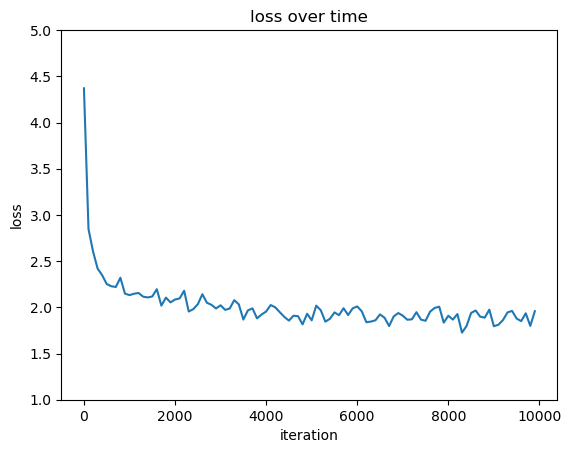

In [ ]:
model = BigramLanguageModel8()
model.to(device)
losses = train_model_and_show_result(model)

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 1.9586102962493896


In [ ]:
generate_some_text(model=model, max_new_tokens=300)


This shame: why ham bast; I sixt ward be took; I'll sincely?
The warr lead me, will deepome fores a bucked shame hid. I'll him
That I:
Well riew,
Whosily stees we and bed
With I this of I'll speap it:
I myscan my larmandring, ere think. I'll time the counden able callow.
Cupper, we dow beatty name b


Our loss keeps going down from:

- 2.553
- 2.298 (scaled dot product attention)
- 2.150 (multi-head attention)
- 2.081 (feed fwd layer)
- 2.16  => blocks without optimization - this is worse; but we're dealing with a deep network here
- 1.96 (blocks optimized with residual pathways)
- 1.855 (inner layer of feedforward is 4 x size of input)
- 1.845 (layer norm)

We'll now also add a layernorm at the end of the transformer, after the last block and right before the input in the last linear layer that decodes into our vocabulary.

In [ ]:
class BigramLanguageModel9(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd)
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd    # B x T x C
        x = self.blocks(x)
        logits = self.lm_head(x)   # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

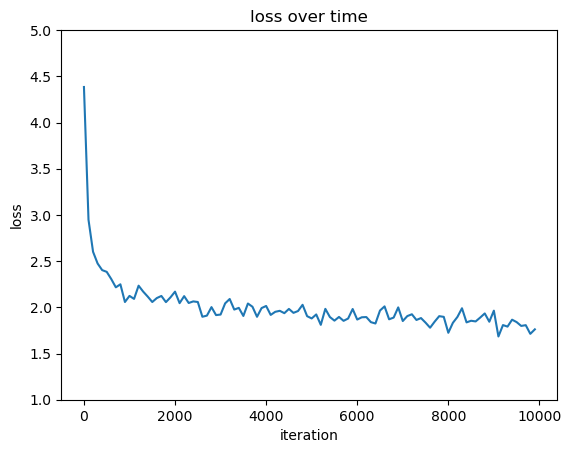

In [ ]:
model = BigramLanguageModel9()
model.to(device)
losses = train_model_and_show_result(model)

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 1.7616101503372192


This is actually a little worse than we had before...

In [ ]:
generate_some_text(model=model, max_new_tokens=100)


If eaching mier, pliffit
And called and her;
And I groof mistly of I can was queal:
try of it come o


## Scaling up our model

Let's see how far we can push this by scaling our model.  To do this, we'll make some changes to make configuration of the model easier.   In addition, we'll add dropout to our head, feedforward layer and multi-head attention.  

Dropout is a regularization technique proposed in a paper from 2014:[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/v15/srivastava14a.html)

See: [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=5870)

In [ ]:
# hyper parameters:
batch_size = 64
block_size = 256     # this was previously only 8
max_iters = 10000
eval_interval = 100
learning_rate = 3e-4 #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384             # number of embedding dimensions
n_head = 6
n_layer = 6
dropout = 0.2        # 20 percent is dropped to zero

class Head(nn.Module):
    """One head of self-attention"""
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)    # n_embd x head_size
        self.query = nn.Linear(n_embd, head_size, bias=False) 
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x)   # (B x T x C) @ () => B x T x C
        q = self.query(x) # B x T x C
        
        # compute attention scores:
        weights = q @ k.transpose(-2,-1) * (C**-0.5) # BxTxC @ BxCxT       => BxTxT
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # BxTxT
        weights = F.softmax(weights, dim=-1) # BxTxT
        weights = self.dropout(weights)
        
        # do weighted aggregation:
        v = self.value(x) # BxTxC
        out = weights @ v # BxTxT @ BxTxC => BxTxC
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of attention in parallel"""
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd) # projection
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))  # projection
        return out

class FeedForward(nn.Module):
    """Single Layer followed by a non-linearity"""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # projection back into residual pathway
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):  # Note: this is unchanged from before
    """Transformer Block: communications followed by computation"""
    
    def __init__(self,n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)  # add layer norm
        self.ln2 = nn.LayerNorm(n_embd)  # add another layer norm
        
    def forward(self, x):
        x = x + self.sa( self.ln1(x))    # the "x + ... is the skip connection here", apply layer norm
        x = x + self.ffwd( self.ln2(x))   # the "x + ... is the skip connection here", apply layer norm
        return x
    
class BigramLanguageModel10(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # give it index in vocab and it looks up the embedding vector in n_embd dims
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # each position will also get its own embedding vector
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for n in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B,T = idx.shape
        
        # idx here is our input indexes, like the vector xb we saw earlier
        # we will get the token embeddings from idx, using our embedding table
        #                                                                             #                             idx dimension: B x T
        tok_embd = self.token_embedding_table(idx)                                    # token embeddings with result dimension:    B x T x C
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))  # position embeddings with result dimension:     T x C
        x = tok_embd + pos_embd    # B x T x C
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)   # (B x T x C) @ (C, vocab_size) = (B x T x vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens:
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]         # pluck out last time step: B x T x C becomes B x C
            probs = F.softmax(logits, dim=-1) # B x C
            idx_next = torch.multinomial(probs, num_samples=1)  # B x 1
            idx = torch.cat((idx, idx_next), dim=1) # B x T+1
        return idx

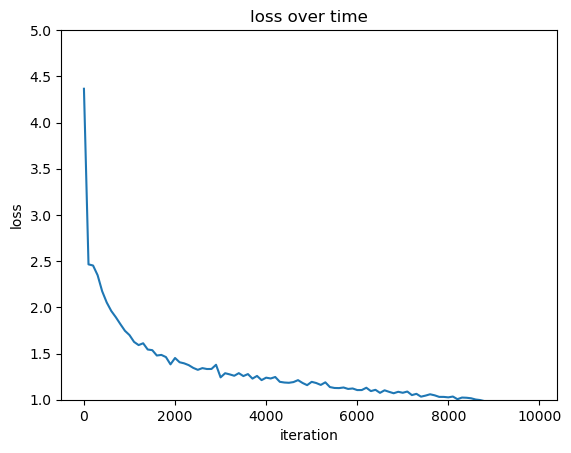

CPU times: user 10min 6s, sys: 26.6 s, total: 10min 32s
Wall time: 10min 29s


In [ ]:
%%time
model = BigramLanguageModel10()
model.to(device)
losses = train_model_and_show_result(model)

In [ ]:
print(f'last recorded loss was {losses[len(losses)-1]}')

last recorded loss was 0.9283599257469177


In [ ]:
generate_some_text(model=model, max_new_tokens=500)


Mark thee, when my poor worthy hob, by banish'd,
Thee light his father, with the garish of looks,
And never crack'd on other ground, which of all.
That time we replied to the time allowing
What cannot pit in?

SICINIUS:
I would tell thee, thou carry what will do,
But ever here in her puts in this such a case.

Both CARLIUS:
Who hath calf but hath believed their house.

Citizen:
I will not be but spark to: cries and give wars this
facting enemy, and I have.

CORIOLANUS:
O this last knowledge for 


In [ ]:
device

'cuda'